In [ ]:
  import pandas as pd

file_path = "EduPro Online Platform.xlsx"

users = pd.read_excel(file_path, sheet_name="Users")
courses = pd.read_excel(file_path, sheet_name="Courses")
transactions = pd.read_excel(file_path, sheet_name="Transactions")
teachers = pd.read_excel(file_path, sheet_name="Teachers")


In [ ]:
users.drop_duplicates(inplace=True)
courses.drop_duplicates(inplace=True)
transactions.drop_duplicates(inplace=True)
teachers.drop_duplicates(inplace=True)

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


In [ ]:
df = transactions.merge(users, on="UserID")
df = df.merge(courses, on="CourseID")
df = df.merge(teachers, on="TeacherID")


In [ ]:
total_courses = df.groupby('UserID')['CourseID'].count().reset_index()
total_courses.rename(columns={'CourseID':'TotalCourses'}, inplace=True)


In [ ]:
enrollment_freq = df.groupby('UserID')['TransactionDate'].count().reset_index()
enrollment_freq.rename(columns={'TransactionDate':'EnrollmentFrequency'}, inplace=True)


In [ ]:
preferred_category = df.groupby(['UserID','CourseCategory']).size().reset_index(name='count')

preferred_category = preferred_category.loc[
    preferred_category.groupby('UserID')['count'].idxmax()
]

preferred_category = preferred_category[['UserID','CourseCategory']]


In [ ]:
preferred_level = df.groupby(['UserID','CourseLevel']).size().reset_index(name='count')

preferred_level = preferred_level.loc[
    preferred_level.groupby('UserID')['count'].idxmax()
]

preferred_level = preferred_level[['UserID','CourseLevel']]


In [ ]:
avg_rating = df.groupby('UserID')['CourseRating'].mean().reset_index()
avg_rating.rename(columns={'CourseRating':'AvgCourseRating'}, inplace=True)


In [ ]:
avg_spend = df.groupby('UserID')['Amount'].mean().reset_index()
avg_spend.rename(columns={'Amount':'AvgSpending'}, inplace=True)


In [ ]:
diversity = df.groupby('UserID')['CourseCategory'].nunique().reset_index()
diversity.rename(columns={'CourseCategory':'DiversityScore'}, inplace=True)


In [ ]:
level_counts = pd.crosstab(df['UserID'], df['CourseLevel'])

level_counts['DepthIndex'] = level_counts.get('Advanced',0) / (
    level_counts.get('Beginner',1)
)

level_counts.reset_index(inplace=True)


In [ ]:
learner_profile = users[['UserID','Age','Gender']]

for feature in [
    total_courses,
    enrollment_freq,
    preferred_category,
    preferred_level,
    avg_rating,
    avg_spend,
    diversity,
    level_counts[['UserID','DepthIndex']]
]:
    learner_profile = learner_profile.merge(feature, on="UserID", how="left")


In [ ]:
learner_profile = pd.get_dummies(
    learner_profile,
    columns=['Gender','CourseCategory','CourseLevel']
)


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

# Replace infinite values with NaN
learner_profile.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values (e.g., with 0 or mean/median depending on the context of the feature)
# For DepthIndex, if no beginner courses, ratio becomes inf, or 0/0 becomes NaN.
# Filling with 0 implies no depth contribution for these cases.
learner_profile.fillna(0, inplace=True)

X_scaled = scaler.fit_transform(
    learner_profile.drop('UserID', axis=1)
)

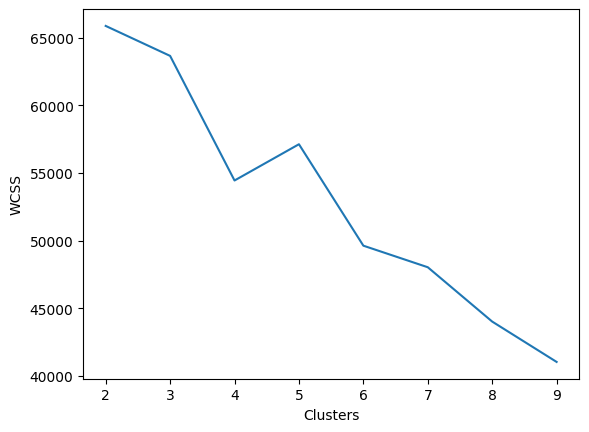

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2,10), wcss)
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
learner_profile['Cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
df_cluster = df.merge(
    learner_profile[['UserID','Cluster']],
    on='UserID'
)

popular_courses = df_cluster.groupby(
    ['Cluster','CourseName']
).size().reset_index(name='Popularity')


In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, learner_profile['Cluster'])
print(score)


0.1338288887891179


In [ ]:
import joblib

# Save learner profile dataset
learner_profile.to_csv("learner_profiles.csv", index=False)

# Save courses dataset
courses.to_csv("courses.csv", index=False)

# Save clustering model
joblib.dump(kmeans, "kmeans_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
print(learner_profile.head())
print(courses.head())
print(kmeans)
print(scaler)


   UserID  Age  TotalCourses  EnrollmentFrequency  AvgCourseRating  \
0  U00001   15             1                    1         1.350000   
1  U00002   29             1                    1         2.880000   
2  U00003   33            11                   11         2.889091   
3  U00004   23            13                   13         3.451538   
4  U00005   21             2                    2         2.055000   

   AvgSpending  DiversityScore  DepthIndex  Gender_Female  Gender_Male  ...  \
0   394.260000               1        0.00          False         True  ...   
1     0.000000               1        0.00           True        False  ...   
2    55.816364               7        1.00           True        False  ...   
3    75.542308               8        0.75           True        False  ...   
4   173.355000               2        1.00          False         True  ...   

   CourseCategory_Finance  CourseCategory_Machine Learning  \
0                   False                 